<a href="https://colab.research.google.com/github/HammadSiddiqui30/Time-series-forecasting-with-LSTM/blob/main/Time_Series_Forecasting_With_RNN(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("monthly_milk_production.csv", index_col = "Date", parse_dates= True)
df.index.freq = "MS"
# index freq to show we are dealing with monthly data

In [6]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

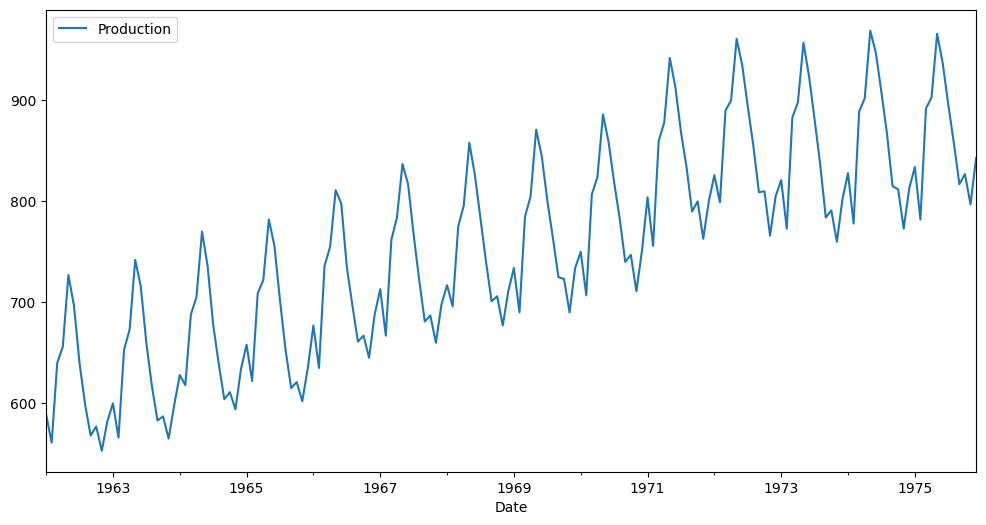

In [7]:
df.plot(figsize= (12,6))

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

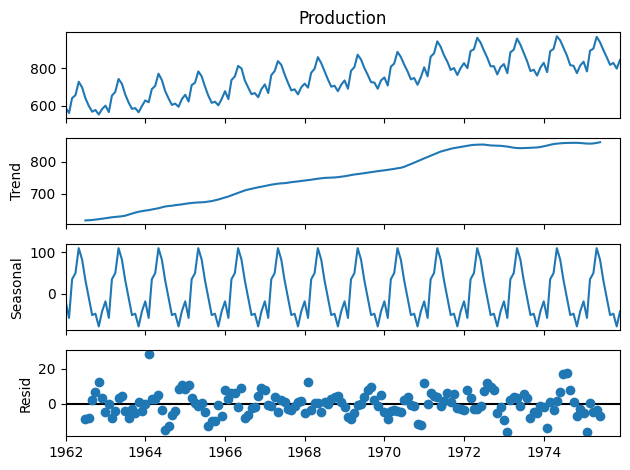

In [12]:
results = seasonal_decompose(df["Production"])
results.plot();
# seasonal graph takes the difference of trend from original
#resid is the noise part of the dataset
# RNN works good on both stationary and non stationary data
# if model is not performing well then convert data to stationary first

In [13]:
len(df)

168

In [15]:
# leave last 12 months for testing
train = df.iloc[:156]
test = df.iloc[156:]

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# preprocess the data to convert dataset from 0-1

In [18]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [27]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [28]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [30]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
n_input = 3 # no. of months
n_features =1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size =1)

In [34]:
# First 3 values are taken as 1 batch and using that it has made a next prediction
X,y = generator[0]
print("Given the array: \n", X.flatten())
print("Predict this y: \n", y)
# Below 2nd 3rd and 4th values are taken to make a 5th prediction
#X,y = generator[1]
#print(f"Given the array: \n{X.flatten()}")
#print(f"Predict this y: \n {y}")


Given the array: 
 [0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [33]:
# There is 1 row at a time, 3 columns and 1 is the number of features
X.shape

(1, 3, 1)

In [35]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size =1)

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [37]:
# Define Model
model = Sequential()
# 100 neurons
model.add(LSTM(100,activation = "relu", input_shape= (n_input,n_features)))
# Final output layer which makes prediction
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
model.fit(generator,epochs =50)

Epoch 1/50
144/144 [==============================] - 3s 9ms/step - loss: 0.0549
Epoch 2/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0239
Epoch 3/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0190
Epoch 4/50
144/144 [==============================] - 2s 10ms/step - loss: 0.0147
Epoch 5/50
144/144 [==============================] - 2s 15ms/step - loss: 0.0085
Epoch 6/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0083
Epoch 7/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 8/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0077
Epoch 9/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0045
Epoch 10/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 11/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0047
Epoch 12/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 13/50
144/144 

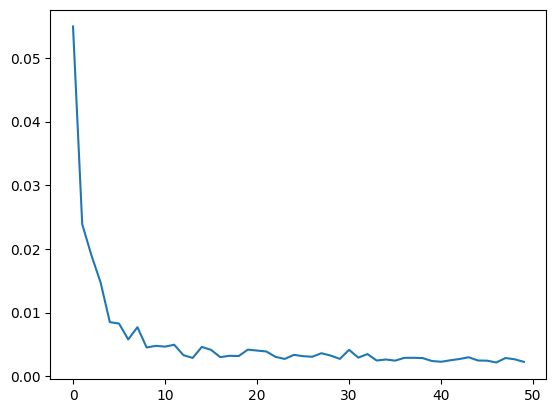

In [40]:
loss_per_epoch = model.history.history["loss"]
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [41]:
last_train_batch = scaled_train[-12:]

In [42]:
last_train_batch = last_train_batch.reshape((1,n_input,n_features))

In [43]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 207ms/step


array([[0.6461707]], dtype=float32)

In [44]:
scaled_test[0]

array([0.67548077])

In [48]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
  #get the prediction value for the first batch
  current_pred = model.predict(current_batch)[0]

  # append the prediction into the array
  test_predictions.append(current_pred)

  # use the prediction to update the batch and remove the first value
  # axis =1 it appends in columns
  current_batch= np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

1/1 [==============================] - 0s 23ms/step


In [49]:
test_predictions

[array([0.6461707], dtype=float32),
 array([0.6358317], dtype=float32),
 array([0.8233362], dtype=float32),
 array([0.9052029], dtype=float32),
 array([1.0112957], dtype=float32),
 array([0.99840784], dtype=float32),
 array([0.925238], dtype=float32),
 array([0.81601274], dtype=float32),
 array([0.6987175], dtype=float32),
 array([0.64800245], dtype=float32),
 array([0.59407794], dtype=float32),
 array([0.63726014], dtype=float32)]

In [55]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,821.807001
1975-02-01,782,817.505993
1975-03-01,892,895.507853
1975-04-01,903,929.564417
1975-05-01,966,973.699001


In [51]:
true_predictions = scaler.inverse_transform(test_predictions)

In [54]:
test["Predictions"] = true_predictions.copy()

<ipython-input-54-d63e10837e78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = true_predictions.copy()


<Axes: xlabel='Date'>

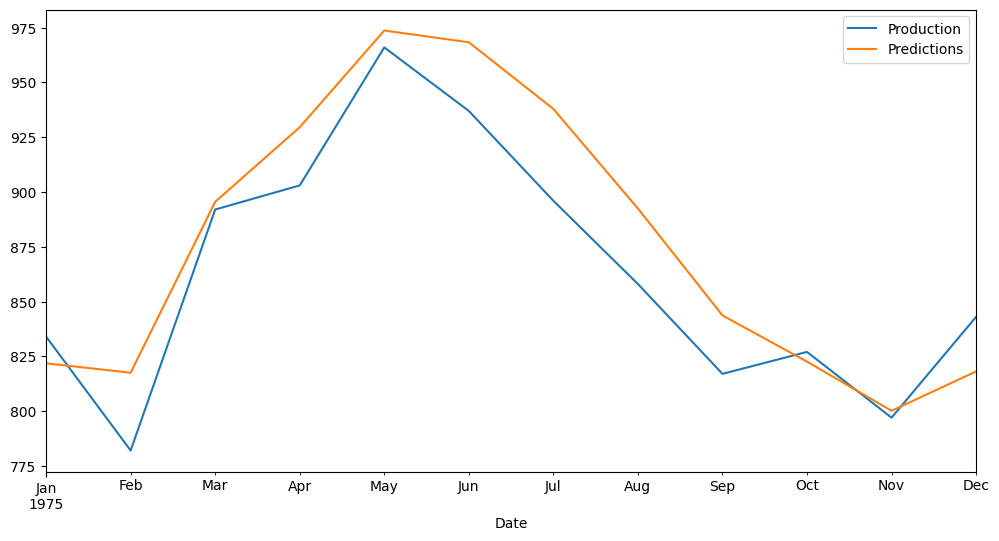

In [56]:
test.plot(figsize=(12,6))

In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test["Production"],test["Predictions"]))
print(rmse)

24.953825252622963
